In [3]:
import main

config_file = main.parse_opt(['-c', 'local_template.json'])
data = main.parse_config(config_file)
config = main.Config(data)


Preprocess to get 
    x: all trail samples of one subject
    y: all labels of one subject


In [4]:
from data.seed_iv import FeatureMethod, Subject
from train.conformer_feature import dataset_of_subject
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

block_size = 10
x, y = dataset_of_subject(
    config.dataset['eeg_feature_smooth_abs_path'], Subject.THREE, FeatureMethod.DE_LDS, block_size
)

# m = ConformerFeature(5)
# summary(m, input_size=(10, 62, 5))

x = np.array(x)
y = np.array(y)




Exploratory data analysis

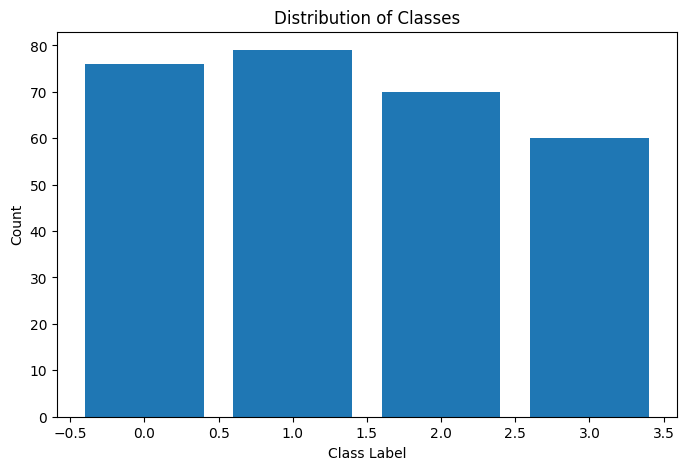

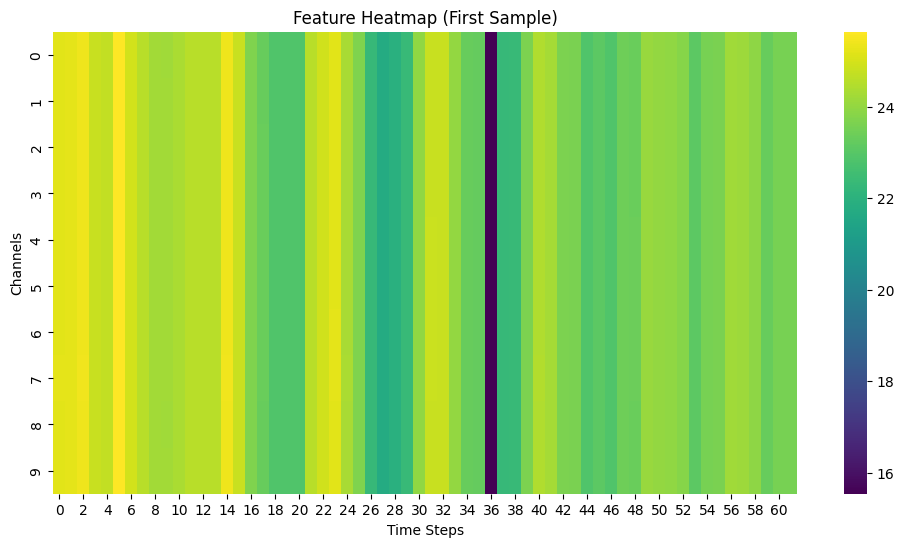

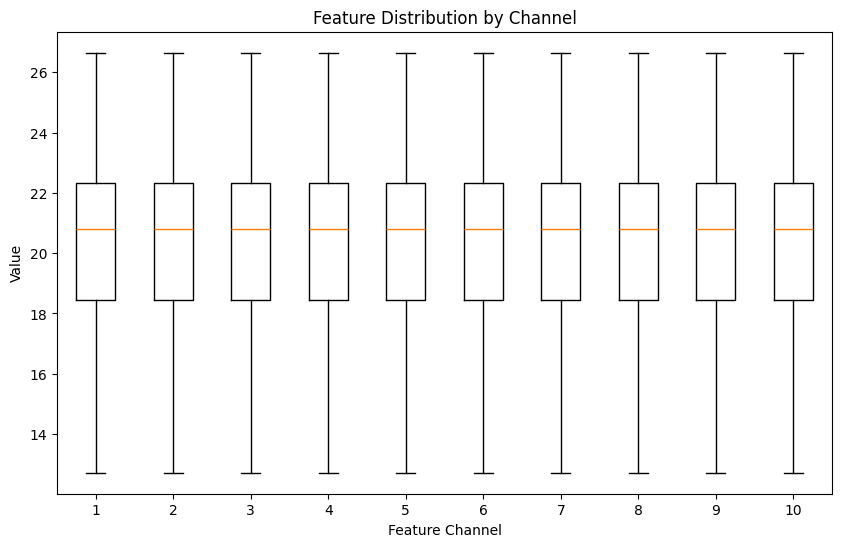

X shape: (285, 5, 10, 62)
Y shape: (285,)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize class distribution
plt.figure(figsize=(8, 5))
unique_labels, counts = np.unique(y, return_counts=True)
plt.bar(unique_labels, counts)
plt.title('Distribution of Classes')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

# 2. Visualize feature patterns
# Plot first sample's features across channels and time
plt.figure(figsize=(12, 6))
sns.heatmap(x[0, 0], cmap='viridis')
plt.title('Feature Heatmap (First Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Channels')
plt.show()

# 3. Feature distribution across all samples
plt.figure(figsize=(10, 6))
plt.boxplot([x[:, :, i].flatten() for i in range(x.shape[2])])
plt.title('Feature Distribution by Channel')
plt.xlabel('Feature Channel')
plt.ylabel('Value')
plt.show()

# Print shape information
print(f"X shape: {x.shape}")  # Should be (n_samples, n_channels, n_features)
print(f"Y shape: {y.shape}")  # Should be (n_samples,)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Original shape: (285, 5, 10, 62)
# 285: time samples/block_size
# 5: frequency bands
# 10: block size
# 62: electrodes

# 1. Reshape the 4D data to 2D for PCA


X_reshaped = x.reshape(x.shape[0], -1)  # Shape will be (285, 5*10*62 = 3100)

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# 3. Apply PCA
pca = PCA()  # no n_components means keep all components
X_pca = pca.fit_transform(X_scaled)

# 4. Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# 5. Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 6. Select number of components (e.g., 95% variance explained)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# 7. Apply PCA with selected components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# 8. Visualize first two components (if you want to see the distribution)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=y, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.colorbar(label='Class')
plt.show()

print(f"X_pca_final shape: {X_pca_final.shape}")


ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [21]:
x = X_pca_final.reshape(x.shape[0], 5, 1, -1)


ValueError: cannot reshape array of size 1710 into shape (285,5,1,newaxis)

In [20]:
from model.conformer_feature import ConformerFeature
import matplotlib.pyplot as plt

# Add lists to store metrics
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create figure for plotting
plt.figure(figsize=(12, 4))

for fold, (train_index, test_index) in enumerate(kf.split(x)):
    print(f"Fold {fold + 1}")

    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    x_train_tensor = torch.from_numpy(np.array(x_train)).float()
    y_train_tensor = torch.from_numpy(np.array(y_train)).long()
    x_test_tensor = torch.from_numpy(np.array(x_test)).float()
    y_test_tensor = torch.from_numpy(np.array(y_test)).long()

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = ConformerFeature(channels=5, block_size=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

    # Initialize fold-specific metric lists
    fold_train_acc = []
    fold_test_acc = []
    fold_train_loss = []
    fold_test_loss = []

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()

        print(f'Epoch: {epoch} ----------------------------')
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(batch_x)

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += predicted.eq(batch_y).sum().item()
            total_samples += batch_y.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                y_pred = model(batch_x)
                loss = criterion(y_pred, batch_y)
                test_loss += loss.item()
                _, predicted = torch.max(y_pred, 1)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()

        test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Store metrics
        fold_train_acc.append(epoch_accuracy)
        fold_train_loss.append(epoch_loss)
        fold_test_acc.append(test_accuracy)
        fold_test_loss.append(test_loss)

    # After training, store fold metrics
    train_accuracies.append(fold_train_acc)
    test_accuracies.append(fold_test_acc)
    train_losses.append(fold_train_loss)
    test_losses.append(fold_test_loss)
    
    print("-" * 40)

print("k-fold end")

Fold 1
Epoch: 0 ----------------------------


RuntimeError: Given groups=1, weight of size [40, 5, 1, 1], expected input[1, 1, 1, 6] to have 5 channels, but got 1 channels instead

<Figure size 1200x400 with 0 Axes>

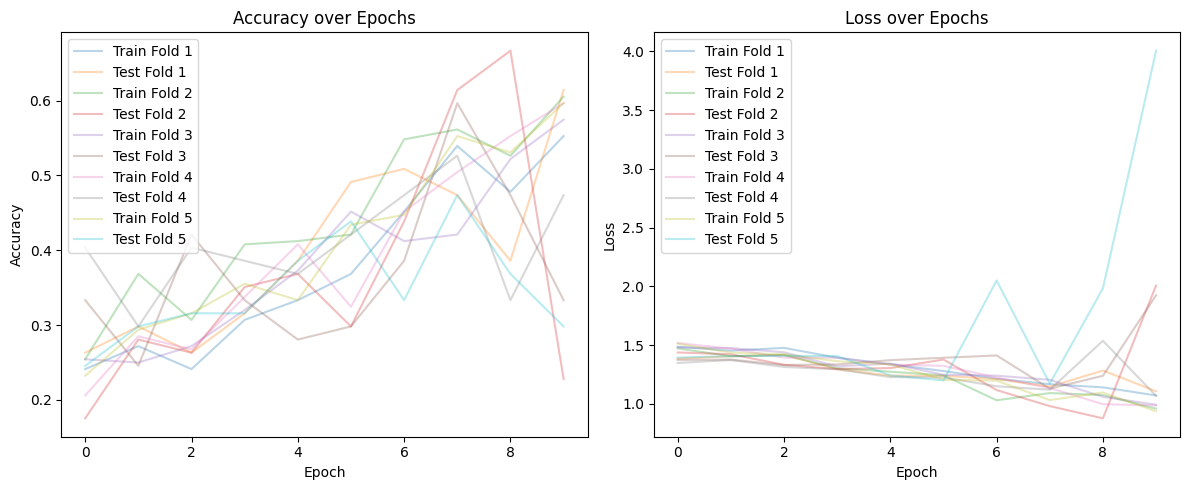

In [12]:
# Plot results
plt.figure(figsize=(12, 5))

# Plot accuracies
plt.subplot(1, 2, 1)
for fold in range(len(train_accuracies)):
    plt.plot(train_accuracies[fold], label=f'Train Fold {fold+1}', alpha=0.3)
    plt.plot(test_accuracies[fold], label=f'Test Fold {fold+1}', alpha=0.3)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
for fold in range(len(train_losses)):
    plt.plot(train_losses[fold], label=f'Train Fold {fold+1}', alpha=0.3)
    plt.plot(test_losses[fold], label=f'Test Fold {fold+1}', alpha=0.3)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()